# 5장 머신러닝의 핵심 이슈

**감사말**: 프랑소와 숄레의 [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff) 5장에 사용된 코드에 대한 설명을 담고 있으며 텐서플로우 2.6 버전에서 작성되었습니다. 소스코드를 공개한 저자에게 감사드립니다.

**tensorflow 버전과 GPU 확인**
- 구글 코랩 설정: '런타임 -> 런타임 유형 변경' 메뉴에서 GPU 지정 후 아래 명령어 실행 결과 확인

    ```
    !nvidia-smi
    ```

- 사용되는 tensorflow 버전 확인

    ```python
    import tensorflow as tf
    tf.__version__
    ```
- tensorflow가 GPU를 사용하는지 여부 확인

    ```python
    tf.config.list_physical_devices('GPU')
    ```

## 주요 내용

- 머신러닝의 핵심 이슈 이해: 모델 일반화와 모델 훈련 최적화 사이의 관계 조율
- 머신러닝 모델 평가 기법
- 모델 훈련 최적화 기법
- 모델 일반화 성능 향상 기법

## 5.1 머신러닝의 목표: 모델 일반화

훈련을 많이 할 수록 모델은 훈련 세트에 대해 보다 좋은 성능을 보이지만 새로운 데이터에 대한 
성능은 점점 떨어지는 과대적합 현상이 언제나 발생한다. 
머신러닝의 핵심 이슈는 모델 훈련의 **최적화**(optimization)와 
모델 **일반화**(generalization) 사이의 관계를 적절히 조절하는 것이다.

- **최적화**: 훈련 세트에 대해 가장 좋은 성능을 이끌어 내는 과정
- **일반화**: 처음 보는 데이터를 처리하는 모델의 능력

### 과소적합과 과대적합

- 과소적합
    - 훈련 초반
    - 훈련셋과 검증셋 모두에 대해 성능이 향상되는 과정
    - 신경망이 훈련셋의 패턴을 아직 덜 파악한 상태

- 과대적합
    - 훈련셋 고유의 패턴을 학습하기 시작
    - 새로운 데이터와 무관하거나 혼동을 주는 패턴 학습

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/typical_overfitting.png" style="width:700px;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

#### 일반화 성능이 좋은 모델 대 과대적합 모델

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/outliers_and_overfitting.png" style="width:660px;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

#### 과대적합 발생 주요 요인

과대적합을 발생시키는 요소는 크게 세 가지로 나뉜다.

##### 첫째, 소음(noise) 섞인 훈련셋.

- 적절하지 않은 데이터 또는 잘못된 레이블을 갖는 데이터 등을 **소음** 또는 **노이즈**(noise)라 부름.
- 적절하지 않은 데이터: 다음 MNNIST 이미지들처럼 불분명하면 특성 파악 어려움.

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/fucked_up_mnist.png" style="width:500px;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

- 잘못된 레이블: 예를 들어, 잘못 분류된 1처럼 생긴 이미지를 7로 잘못 분류할 가능성이 높아짐.

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/mislabeled_mnist.png" style="width:660px;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

##### 둘째, 애매한 특성.

- 소음이 전혀 없는 데이터라 하더라도 특정 특성 영역이 여러 레이블과 연관될 수 있음.

- 예제: 붓꽃 데이터의 꽃잎 길이와 너비를 활용한 
    버시컬러(versicolor) 품종과 버지니카(virginica) 품종의 완벽한 구분 불가능.

<div align="center"><img src="https://codingalzi.github.io/handson-ml2/slides/images/ch05/homl05-03b.png" style="width:500px;"></div>

##### 셋째: 매우 드문 특성 또는 거짓 상관관계

- 매우 드문 특성
    - 예제: IMDB 데이터셋에서 매우 낮은 빈도로 사용되는 단어를 훈련셋에서 포함시키는 경우
        어쩌다 한 번 사용되는 특성으로 인해 잘못된 판단이 유도될 수 있음.

- 거짓된 상관관계를 유발하는 훈련셋
- 예제: MNIST 데이터셋에 **백색 소음**(white noise)이 포함된 데이터셋과 그렇지 않은 데이터셋 비교 참조.

In [1]:
from tensorflow.keras.datasets import mnist
import numpy as np

# MNIST 데이터셋 적재 및 전처리
(train_images, train_labels), _ = mnist.load_data()

train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255

# 백색 소음 추가
train_images_with_noise_channels = np.concatenate(
    [train_images, np.random.random((len(train_images), 784))], axis=1)

# 크기를 맞추기 위해 영 행렬 추가
train_images_with_zeros_channels = np.concatenate(
    [train_images, np.zeros((len(train_images), 784))], axis=1)

11490434/11490434 [==============================] - 0s 0us/step


In [2]:
train_images_with_noise_channels.shape

(60000, 1568)

In [3]:
train_images_with_zeros_channels.shape

(60000, 1568)

백색 소음이 들어간 샘플은 다음과 같이 보인다.

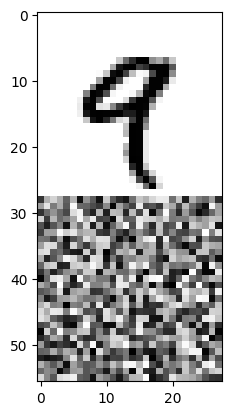

In [4]:
train_image_white4 = train_images_with_noise_channels[4].reshape((56, 28))

import matplotlib.pyplot as plt

digit = train_image_white4
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

영 행렬이 추가된 샘플은 다음과 같이 보인다.

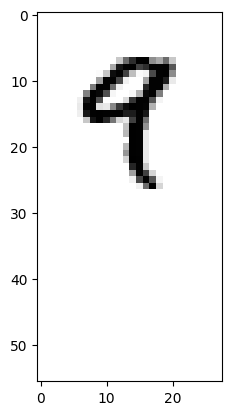

In [5]:
train_image_zeros4 = train_images_with_zeros_channels[4].reshape((56, 28))

import matplotlib.pyplot as plt

digit = train_image_zeros4
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

모델 구성과 컴파일을 함수를 이용하여 지정한다.

- 정수 레이블을 사용하기에 손실함수로 `sparse_categorical_crossentropy` 지정해야 함.

In [6]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model():
    model = keras.Sequential([
        layers.Dense(512, activation="relu"),
        layers.Dense(10, activation="softmax")
    ])
    
    model.compile(optimizer="rmsprop",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    
    return model

- 백색 소음이 추가된 데이터셋 훈련
    - `validation_split`: 검증셋 비율 지정

In [7]:
# 모델 생성 및 훈련
model = get_model()

history_noise = model.fit(
    train_images_with_noise_channels, train_labels,
    epochs=10,
    batch_size=128,
    validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 9s 6ms/step - loss: 0.6232 - accuracy: 0.8085 - val_loss: 0.2555 - val_accuracy: 0.9265
Epoch 2/10
375/375 [==============================] - 1s 3ms/step - loss: 0.2564 - accuracy: 0.9215 - val_loss: 0.2009 - val_accuracy: 0.9398
Epoch 3/10
375/375 [==============================] - 1s 4ms/step - loss: 0.1692 - accuracy: 0.9480 - val_loss: 0.1819 - val_accuracy: 0.9447
Epoch 4/10
375/375 [==============================] - 1s 3ms/step - loss: 0.1199 - accuracy: 0.9629 - val_loss: 0.1607 - val_accuracy: 0.9505
Epoch 5/10
375/375 [==============================] - 1s 3ms/step - loss: 0.0892 - accuracy: 0.9718 - val_loss: 0.1575 - val_accuracy: 0.9529
Epoch 6/10
375/375 [==============================] - 1s 3ms/step - loss: 0.0650 - accuracy: 0.9797 - val_loss: 0.1719 - val_accuracy: 0.9523
Epoch 7/10
375/375 [==============================] - 1s 4ms/step - loss: 0.0476 - accuracy: 0.9850 - val_loss: 0.1461 - val_accuracy: 0.9584
Epoch 

- 영 행렬이 추가된 데이터셋 훈련
    - `validation_split`: 검증셋 비율 지정

In [ ]:
model = get_model()
history_zeros = model.fit(
    train_images_with_zeros_channels, train_labels,
    epochs=10,
    batch_size=128,
    validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 3s 6ms/step - loss: 0.2910 - accuracy: 0.9169 - val_loss: 0.1713 - val_accuracy: 0.9503
Epoch 2/10
375/375 [==============================] - 2s 6ms/step - loss: 0.1226 - accuracy: 0.9643 - val_loss: 0.1203 - val_accuracy: 0.9631
Epoch 3/10
375/375 [==============================] - 2s 6ms/step - loss: 0.0791 - accuracy: 0.9764 - val_loss: 0.0982 - val_accuracy: 0.9708
Epoch 4/10
375/375 [==============================] - 2s 6ms/step - loss: 0.0569 - accuracy: 0.9835 - val_loss: 0.0893 - val_accuracy: 0.9746
Epoch 5/10
375/375 [==============================] - 2s 6ms/step - loss: 0.0431 - accuracy: 0.9871 - val_loss: 0.0765 - val_accuracy: 0.9780
Epoch 6/10
375/375 [==============================] - 2s 6ms/step - loss: 0.0330 - accuracy: 0.9900 - val_loss: 0.0898 - val_accuracy: 0.9757
Epoch 7/10
375/375 [==============================] - 2s 6ms/step - loss: 0.0246 - accuracy: 0.9926 - val_loss: 0.0832 - val_accuracy: 0.9781
Epoch 

- 정확도 비교: 백색 소음이 포함된 훈련셋을 이용한 모델의 정확도 성능이 1% 이상 낮음.

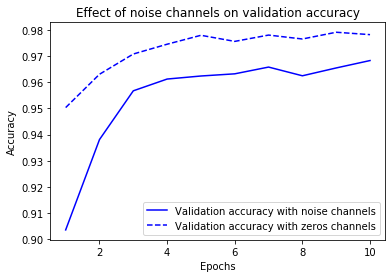

In [ ]:
import matplotlib.pyplot as plt

val_acc_noise = history_noise.history["val_accuracy"]
val_acc_zeros = history_zeros.history["val_accuracy"]

epochs = range(1, 11)

plt.plot(epochs, val_acc_noise, "b-",
         label="Validation accuracy with noise channels")

plt.plot(epochs, val_acc_zeros, "b--",
         label="Validation accuracy with zeros channels")

plt.title("Effect of noise channels on validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

**특성 선택**

- 과대적합 문제를 위해 훈련에 유용한 특성을 선택해야함.
    - IMDB 예제: 빈도수 10,000 등 이내의 단어만 사용
    - 백색 소음 예제: 백색 소음 부분 제거
- 하지만 유용한 특성을 선택하는 일이 기본적으로 불가능하거나 매우 어려움.

### 딥러닝 모델 일반화의 핵심

아래 예제에서 확인할 수 있듯이 딥러닝 모델은 어떤 무엇도 학습할 수 있다.

**예제: MNIST 모델을 임의로 섞은 레이블과 함께 훈련시키기**

아래 코드는 임의로 섞은 레이블을 이용하여 손글씨를 예측하는 모델을 훈련시킨다. 

In [ ]:
(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255

random_train_labels = train_labels[:]
np.random.shuffle(random_train_labels)

model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])

model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(train_images, random_train_labels,
                    epochs=100,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/100
375/375 [==============================] - 2s 4ms/step - loss: 2.3160 - accuracy: 0.1028 - val_loss: 2.3059 - val_accuracy: 0.1075
Epoch 2/100
375/375 [==============================] - 1s 4ms/step - loss: 2.2996 - accuracy: 0.1146 - val_loss: 2.3174 - val_accuracy: 0.1070
Epoch 3/100
375/375 [==============================] - 1s 4ms/step - loss: 2.2908 - accuracy: 0.1272 - val_loss: 2.3171 - val_accuracy: 0.0995
Epoch 4/100
375/375 [==============================] - 1s 4ms/step - loss: 2.2773 - accuracy: 0.1397 - val_loss: 2.3299 - val_accuracy: 0.1021
Epoch 5/100
375/375 [==============================] - 1s 4ms/step - loss: 2.2598 - accuracy: 0.1543 - val_loss: 2.3369 - val_accuracy: 0.1011
Epoch 6/100
375/375 [==============================] - 1s 4ms/step - loss: 2.2398 - accuracy: 0.1665 - val_loss: 2.3438 - val_accuracy: 0.1001
Epoch 7/100
375/375 [==============================] - 1s 4ms/step - loss: 2.2154 - accuracy: 0.1839 - val_loss: 2.3700 - val_accuracy: 0.0989

Epoch 58/100
375/375 [==============================] - 1s 4ms/step - loss: 0.9603 - accuracy: 0.6778 - val_loss: 4.5799 - val_accuracy: 0.1044
Epoch 59/100
375/375 [==============================] - 1s 4ms/step - loss: 0.9430 - accuracy: 0.6866 - val_loss: 4.6532 - val_accuracy: 0.1037
Epoch 60/100
375/375 [==============================] - 1s 4ms/step - loss: 0.9299 - accuracy: 0.6905 - val_loss: 4.7384 - val_accuracy: 0.1014
Epoch 61/100
375/375 [==============================] - 1s 4ms/step - loss: 0.9151 - accuracy: 0.6943 - val_loss: 4.7840 - val_accuracy: 0.1028
Epoch 62/100
375/375 [==============================] - 1s 4ms/step - loss: 0.9030 - accuracy: 0.7001 - val_loss: 4.8333 - val_accuracy: 0.1038
Epoch 63/100
375/375 [==============================] - 1s 4ms/step - loss: 0.8879 - accuracy: 0.7061 - val_loss: 4.8799 - val_accuracy: 0.1019
Epoch 64/100
375/375 [==============================] - 1s 4ms/step - loss: 0.8762 - accuracy: 0.7082 - val_loss: 4.9496 - val_accuracy:

훈련셋에 대한 성능은 훈련하면서 계속 향상되지만 검증셋에 성능은 전혀 향상되지 않는다.

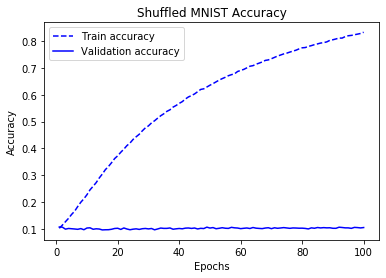

In [ ]:
import matplotlib.pyplot as plt

train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

epochs = range(1, 101)

plt.plot(epochs, train_acc, "b--",
         label="Train accuracy")

plt.plot(epochs, val_acc, "b-",
         label="Validation accuracy")

plt.title("Shuffled MNIST Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

위 결과는 다음을 의미한다.

- 일반화는 모델 훈련 과정 중에 제어할 수 있는 대상이 아니다. 
- 모델 훈련을 통해 할 수 있는 것은 주어진 훈련 데이터셋에 모델이 적응하도록 하는 것 뿐이다.
- 딥러닝 모델은 어떤 데이터셋에도 적응할 수 있기에 
    너무 오래 훈련시키면 과대적합은 반드시 발생하고 일반화는 어려워진다. 

결론적으로 **일반화**가 모델 보다는 사용되는 **데이터셋 내부에 존재하는 정보 구조**와 
보다 밀접히 관련된다고 볼 수 있다. 

#### 다양체 가설

일반적인 데이터셋은 고차원상에 존재하는 (저차원의) 연속이며 미분가능한 다양체를 구성한다는 가설이
**다양체 가설**(manifold hypothesis)이다.
그리고 모델 훈련은 바로 이 다양체를 찾아가는 과정이다. 

**참고**: 이런 의미에서 무작위로 섞은 레이블을 사용하는 위 MNIST 예제는 일반적인 데이터셋이 될 수 없다. 

아래 이미지는 3차원 공간에 존재하는 2차원 다양체를 고차원 상의 다양체로 변환하여 선형 분류가 가능한
데이터셋을 구성하는 과정을 보여준다.

<div align="center"><img src="https://codingalzi.github.io/handson-ml2/slides/images/ch08/homl08-13.png" style="width:550px;"></div>

그림 출처: [핸즈온 머신러닝(2판), 8장](https://github.com/ageron/handson-ml2)

다양체 가설을 이용하면 적절하게 구성된 모델이 적절한 훈련셋으로 훈련받았을 때 새로운 데이터에 대해 적절한 예측을 할 수 있는 이유를 설명할 수 있다.
즉, 모델이 찾은 연속이며 미분가능한 다양체와 학습된 데이터 정보에 **보간법**을 적용하여 새로운 데이터에 대해 예측을 실행한다.

#### 보간법

**보간법**(interpolation)은 모델 훈련에 사용된 훈련셋의 데이터와 새로운 데이터를 연결하는 
다양체 상의 경로를 이용하여 예측값을 실행하는 것을 의미한다. 
보다 큰 훈련셋을 사용할 수록 보간법이 보다 잘 작동하지만 
**차원의 저주**(curse of dimensions)로 인해 충분한 크기의 훈련셋 구하기가 
일반적으로 불가능하거나 매우 어렵다. 
    
**참고**: 사람은 보간법 이외의 다른 능력을 사용하여 사물 예측과 구분, 주변 파악, 상황 판단 등 
일반화를 실행한다.

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/dense_sampling.png" style="width:660px;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

#### 충분치 않은 훈련셋과 정규화

충분히 큰 훈련셋을 준비하지 못하면 예측 과정에서 과대한 추측을 하게되어 과대적합이 발생할 가능성이 높다.
이를 방지하기 위해 일반적으로 두 가지 방법을 사용한다.

- 모델에 저장되는 정보를 적절하게 조정하기
- 모델이 생성하는 다양체의 곡률 완화

위 두 방법을 통해 데이터셋의 너무 세세한 패턴 보다는 가장 눈에 띄는 핵심적인 패턴에 모델이 집중하도록 한다.
이런식으로 과대적합을 방지하여 일반화를 향상시키는 기법을 **정규화**(regularization)이라 부른다.

## 5.2 모델 평가

모델의 일반화 능력을 향상시키려면 주어진 모델의 일반화 능력을 평가할 수 있어야 하며,
이를 위해 데이터셋을 훈련셋, 검증셋, 테스트셋으로 구분하는 이유를 먼저 알아야 한다. 

### 모델 튜닝과 정보 유출

훈련셋, 테스트셋 이외에 검증셋을 사용해야 하는 이유는 
무엇보다도 **최적의 모델을 구성할 때 검증셋에 대한 결과가 반영되기 때문**이다. 

테스트셋은 모델 구성과 훈련에 전혀 관여하지 않아야 한다.
따라서 구성된 모델의 성능을 평가하려면 테스트셋을 제외한 다른 데이터셋이 필요하고
이를 위해 훈련셋의 일부를 검증셋으로 활용한다.
검증셋은 훈련 과정 중에 일반화 성능을 테스트하는 용도로 사용되며
이를 통해 레이어 종류 및 개수, 레이어 별 유닛 개수 등 모델 구성에 필요한
**하이퍼파라미터**(hyperparameter)를 조정한다. 
이것을 **모델 튜닝**(model tuning)이라 하며,
바로 이 모델 튜닝을 위해 검증셋이 사용되는 것이다. 

모델 튜닝도 모델의 좋은 하이퍼파라미터를 찾아가는 일종의 **학습**이다. 
따라서 튜닝을 많이 하게되면 검증셋에 대한 과대적합이 발생한다.
다시 말해, 검증셋에 특화된 튜닝을 하게 되어 모델의 일반화 성능이 떨어질 수 있게 된다. 
이런 현상을 **정보 유출**이라 부르는데,
이유는 튜닝을 하면 할 수록 검증셋에 대한 보다 많은 정보가 모델로 흘려들어가기 때문이다. 

**참고**: 하이퍼파라미터와 파라미터는 다르다. 
파라미터(parameter)는 모델 훈련 중에 학습되는 가중치, 편향 등을 가리킨다. 

### 훈련셋, 검증셋, 테스트셋 분류 방법

데이터셋을 훈련셋, 검증셋, 테스트셋으로 분류하여 모델을 훈련을 진행하는
전형적인 방식 세 가지를 소개한다. 

#### 홀드아웃(hold-out) 검증

훈련셋의 일부를 검증셋으로 사용하는 가장 일반적인 방법이며,
모델 훈련 후에 테스트셋을 이용하여 모델의 일반화 성능을 확인한다.
하지만 그 이후에 모델 튜닝을 진행하지 않아야 한다. 

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/holdout_validation.png" style="width:400px;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

홀드아웃 검증의 전형적인 패턴은 다음과 같다.

---
```python
num_validation_samples = 10000

np.random.shuffle(data)

validation_data = data[:num_validation_samples]
training_data = data[num_validation_samples:]

model = get_model()
model.fit(training_data, ...)

validation_score = model.evaluate(validation_data, ...)

...

model = get_model()
model.fit(np.concatenate([training_data,
                          validation_data]), ...)

test_score = model.evaluate(test_data, ...)
```
---

#### K-겹 교차검증

모델의 성능이 사용되는 훈련셋에 따라 심하게 달라질 때 추천되는 검증기법이다. 

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/k_fold_validation.png" style="width:650px;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

K-겹 교차검증의 전형적인 패턴은 다음과 같다.

---
```python
k = 3
num_validation_samples = len(data) // k

np.random.shuffle(data)

validation_scores = []

for fold in range(k):
    validation_data = data[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    training_data = np.concatenate(
        data[:num_validation_samples * fold],
        data[num_validation_samples * (fold + 1):])
    
    model = get_model()
    model.fit(training_data, ...)
    
    validation_score = model.evaluate(validation_data, ...)
    validation_scores.append(validation_score)

validation_score = np.average(validation_scores)

model = get_model()
model.fit(data, ...)

test_score = model.evaluate(test_data, ...)
```
---

#### 반복 K-겹 교차검증

훈련셋의 크기가 너무 작거나 모델의 성능을 최대한 정확하게 평가하기 위해 사용된다.
K-겹 교차검증을 여러 번 실행한다. 대신 매번 훈련셋을 무작위로 섞은 뒤에
교차검증을 실행한다. 
최종 결과는 각 교차검증의 평균값을 사용한다. 
훈련 시간이 매우 오래 걸린다는 게 이 방법의 단점이다. 
K-겹 교차 검증을 P번 반복하면 총 `P * K` 개의 모델을 훈련시키게 된다.

### 모델 성능 평가의 기준선

모델 훈련이 시작되면 평가지표(metrics)를 지켜보는 일 이외에 할 수 있는 게 없다.
따라서 검증셋에 대한 평가지표가 특정 기준선 이상인지를 아는 게 매우 중요하다.

기준선 예제

- MNIST 데이터셋: 10%의 정확도
- IMDB 데이터셋: 50%의 정확도
- 로이터 통신 기사: 18-19의 정확도. 이런 경우 정밀도 등 정확도 이외의 다른 평가기준도 고려 가능.

기준선을 넘는 모델을 생성하는 것이 기본 목표이어야 함.
그렇지 않다면 무언가 잘못된 모델을 또는 잘못된 접근법을 사용하고 있을 가능성이 큼.

### 데이터셋 준비 관련 주의사항

최적화된 모델 훈련을 위해 아래 세 가지 사항을 준수하며 훈련셋, 검증셋, 테스트셋을 
준비해야 한다. 

- **대표성**: 일반적으로 데이터셋을 무작위로 섞어 레이블이 적절한 비율로 섞인 
    훈련셋, 검증셋, 테스트셋을 구성해야 한다.
- **시간의 흐름**: 미래를 예측하는 모델을 훈련시킬 때, 테스트셋의 데이터는 훈련셋의 데이터보다
    시간상 뒤쪽에 위치하도록 해야 한다. 그렇지 않으면 미래 정보가 모델에 유출된다.
    즉, 데이터를 무작위로 섞어 훈련셋과 테스트셋으로 구분하는 일은 하지 않아야 한다. 
- **중복 데이터 제거**: 훈련셋과 테스트셋에 동일한 데이터가 들어가지 않도록 중복 데이터를 제거해야 한다.

## 5.3 모델 훈련 개선법

모델 훈련을 최적화하려면 먼저 과대적합을 달성해야 한다.
이유는 과대적합이 나타나야만 과대적합의 경계를 알아내서 모델 훈련을
언제 멈추어야 하는지 알 수 있기 때문이다. 
일단 과대적합의 경계를 찾은 다음에 일반화 성능을 목표로 삼아야 한다.

모델 훈련 중에 발생하는 문제는 크게 세 종류이다. 

- 첫째, 훈련셋의 손실값이 줄어들지 않아 훈련이 제대로 진행되지 않는 경우
- 둘째, 훈련셋의 손실값은 줄어들지만 검증셋의 성능은 평가 기준선을 넘지 못하는 경우
- 셋째, 훈련셋과 검증셋의 평가가 기준선을 넘어 계속 좋아지지만 과대적합이 발생하지 않는 경우

### 첫째 경우: 경사하강법 관련 파라미터 조정

훈련셋의 손실값이 줄어들지 않거나 진동하는 등 훈련이 제대로 이루어지지 않는 경우는
기본적으로 학습률과 배치 크기를 조절하면 해결된다. 

**MNIST 모델 훈련: 매우 큰 학습률 사용**

- 학습률: 1 (옵티마이저의 옵션에서 지정)
- 훈련셋/검증셋에 대한 정확도가 30% 수준에 머무름.

In [ ]:
(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255

model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer=keras.optimizers.RMSprop(1.),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=10,
          batch_size=128,
          validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 2s 4ms/step - loss: 1052.2745 - accuracy: 0.3604 - val_loss: 2.0373 - val_accuracy: 0.2853
Epoch 2/10
375/375 [==============================] - 1s 4ms/step - loss: 4.9106 - accuracy: 0.2501 - val_loss: 2.0671 - val_accuracy: 0.2453
Epoch 3/10
375/375 [==============================] - 1s 4ms/step - loss: 2.9203 - accuracy: 0.2402 - val_loss: 2.1236 - val_accuracy: 0.2192
Epoch 4/10
375/375 [==============================] - 1s 4ms/step - loss: 2.5024 - accuracy: 0.2362 - val_loss: 2.3967 - val_accuracy: 0.2854
Epoch 5/10
375/375 [==============================] - 1s 4ms/step - loss: 2.6780 - accuracy: 0.2364 - val_loss: 2.1830 - val_accuracy: 0.2910
Epoch 6/10
375/375 [==============================] - 1s 4ms/step - loss: 2.8584 - accuracy: 0.2582 - val_loss: 2.4019 - val_accuracy: 0.2674
Epoch 7/10
375/375 [==============================] - 1s 4ms/step - loss: 2.5525 - accuracy: 0.2406 - val_loss: 2.4998 - val_accuracy: 0.2412
Epo

<div align="center"><img src="https://codingalzi.github.io/handson-ml2/slides/images/ch04/homl04-03.png" style="width:550px;"></div>

그림 출처: [핸즈온 머신러닝(2판), 4장](https://github.com/ageron/handson-ml2)

**MNIST 모델 훈련: 매우 작은 학습률 사용**

- 학습률: 0.000001
- 검증셋에 대한 정확도가 느리게 증가함

In [ ]:
(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255

model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer=keras.optimizers.RMSprop(1e-6),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=10,
          batch_size=128,
          validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 2s 4ms/step - loss: 2.2697 - accuracy: 0.1516 - val_loss: 2.2277 - val_accuracy: 0.1837
Epoch 2/10
375/375 [==============================] - 1s 4ms/step - loss: 2.1804 - accuracy: 0.2286 - val_loss: 2.1383 - val_accuracy: 0.2746
Epoch 3/10
375/375 [==============================] - 1s 4ms/step - loss: 2.0952 - accuracy: 0.3267 - val_loss: 2.0523 - val_accuracy: 0.3807
Epoch 4/10
375/375 [==============================] - 1s 4ms/step - loss: 2.0135 - accuracy: 0.4342 - val_loss: 1.9703 - val_accuracy: 0.4834
Epoch 5/10
375/375 [==============================] - 1s 4ms/step - loss: 1.9346 - accuracy: 0.5261 - val_loss: 1.8906 - val_accuracy: 0.5653
Epoch 6/10
375/375 [==============================] - 1s 4ms/step - loss: 1.8583 - accuracy: 0.5959 - val_loss: 1.8137 - val_accuracy: 0.6258
Epoch 7/10
375/375 [==============================] - 1s 4ms/step - loss: 1.7843 - accuracy: 0.6465 - val_loss: 1.7392 - val_accuracy: 0.6702
Epoch 

<div align="center"><img src="https://codingalzi.github.io/handson-ml2/slides/images/ch04/homl04-02.png" style="width:550px;"></div>

그림 출처: [핸즈온 머신러닝(2판), 4장](https://github.com/ageron/handson-ml2)

**MNIST 모델 훈련: 적절한 학습률 사용**

- 학습률: 0.01
- 제대로 훈련됨.

In [ ]:
model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer=keras.optimizers.RMSprop(1e-2),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=10,
          batch_size=128,
          validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 2s 4ms/step - loss: 0.3792 - accuracy: 0.9103 - val_loss: 0.1304 - val_accuracy: 0.9647
Epoch 2/10
375/375 [==============================] - 1s 4ms/step - loss: 0.1415 - accuracy: 0.9639 - val_loss: 0.1536 - val_accuracy: 0.9676
Epoch 3/10
375/375 [==============================] - 1s 4ms/step - loss: 0.1131 - accuracy: 0.9730 - val_loss: 0.2516 - val_accuracy: 0.9557
Epoch 4/10
375/375 [==============================] - 1s 4ms/step - loss: 0.0985 - accuracy: 0.9783 - val_loss: 0.2125 - val_accuracy: 0.9607
Epoch 5/10
375/375 [==============================] - 1s 4ms/step - loss: 0.0838 - accuracy: 0.9819 - val_loss: 0.1953 - val_accuracy: 0.9707
Epoch 6/10
375/375 [==============================] - 1s 4ms/step - loss: 0.0710 - accuracy: 0.9849 - val_loss: 0.2379 - val_accuracy: 0.9707
Epoch 7/10
375/375 [==============================] - 1s 4ms/step - loss: 0.0726 - accuracy: 0.9860 - val_loss: 0.2317 - val_accuracy: 0.9747
Epoch 

<div align="center"><img src="https://codingalzi.github.io/handson-ml2/slides/images/ch04/homl04-01.png" style="width:550px;"></div>

그림 출처: [핸즈온 머신러닝(2판), 4장](https://github.com/ageron/handson-ml2)

**배치 크기 조정**

- 학습률 이외에 배치크기를 키우면 보다 안정적으로 훈련이 됨. 단, 계산량이 많아질 수 있음.
- 아래 그림에서 확인할 수 있듯이, 배치 크기가 클 수록 보다 일관되게 학습됨.

<div align="center"><img src="https://codingalzi.github.io/handson-ml2/slides/images/ch04/homl04-05.png" style="width:550px;"></div>

그림 출처: [핸즈온 머신러닝(2판), 4장](https://github.com/ageron/handson-ml2)

### 둘째 경우: 보다 적절한 모델 사용

훈련은 잘 진행되는데 검증셋에 대한 성능이 좋아지지 않는다면 다음 두 가지 경우를 의심해 보아야 한다. 

- 좋은 예측값을 구성할 정도로 충분한 정보가 훈련셋에 담겨있지 않는 경우
    - 예제: 레이블이 무작위로 섞인 MNIST 데이터셋
- 사용하는 모델이 적절하지 않은 경우
    - 예제: 선형 분류가 불가능한 데이터셋에 선형분류 모델을 적용하는 경우
    - 예제: 시계열 데이터 분석에 앞서 살펴본 `Sequential` 모델을 사용하는 경우(나중에 확인할 것임)
    
기본적으로, 문제 해결을 위한 적절한 가정을 사용하는 모델을 훈련시켜야 한다.
앞으로 다양한 문제에 적용되는 다양한 모델 구성과 훈련을 살펴볼 것이다.

### 셋째 경우: 모델의 저장 능력 조정

모델의 훈련셋/검증셋의 평가지표가 계속 향상되지만 과대적합이 발생하지 않는 경우 
기본적으로 모델의 정보 저장 능력을 키워야 한다. 

먼저 아래 예제를 살펴보자. 

**MNIST 데이터셋 다중클래스 분류: 매우 단순한 모델**

- 은닉층이 없이 출력층 하나만 사용하는 매우 단순한 모델.
- 검증셋의 정확도: 93% 정도에서 정체
- 검증셋의 손실값: 0.25 이하로 내려가지 않음.

결론적으로 모델의 정보 저장/분석 능력이 떨어진다. 

In [ ]:
model = keras.Sequential([layers.Dense(10, activation="softmax")])

model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

history_small_model = model.fit(
    train_images, train_labels,
    epochs=20,
    batch_size=128,
    validation_split=0.2)

Epoch 1/20
375/375 [==============================] - 1s 1ms/step - loss: 0.6539 - accuracy: 0.8410 - val_loss: 0.3580 - val_accuracy: 0.9057
Epoch 2/20
375/375 [==============================] - 0s 794us/step - loss: 0.3504 - accuracy: 0.9039 - val_loss: 0.3074 - val_accuracy: 0.9145
Epoch 3/20
375/375 [==============================] - 0s 868us/step - loss: 0.3152 - accuracy: 0.9126 - val_loss: 0.2907 - val_accuracy: 0.9184
Epoch 4/20
375/375 [==============================] - 0s 796us/step - loss: 0.2994 - accuracy: 0.9170 - val_loss: 0.2811 - val_accuracy: 0.9213
Epoch 5/20
375/375 [==============================] - 0s 788us/step - loss: 0.2896 - accuracy: 0.9194 - val_loss: 0.2757 - val_accuracy: 0.9234
Epoch 6/20
375/375 [==============================] - 0s 829us/step - loss: 0.2832 - accuracy: 0.9214 - val_loss: 0.2719 - val_accuracy: 0.9248
Epoch 7/20
375/375 [==============================] - 0s 1ms/step - loss: 0.2784 - accuracy: 0.9229 - val_loss: 0.2705 - val_accuracy: 0.9

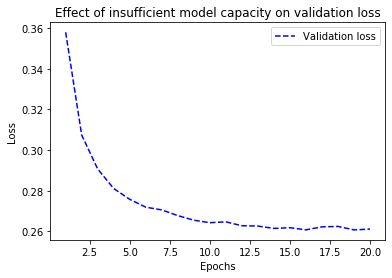

In [ ]:
import matplotlib.pyplot as plt

val_loss = history_small_model.history["val_loss"]
epochs = range(1, 21)

plt.plot(epochs, val_loss, "b--",
         label="Validation loss")

plt.title("Effect of insufficient model capacity on validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

**MNIST 데이터셋 다중클래스 분류: 보다 많은 저장/분석/표현 능력 모델**

- 두 개의 은닉층: 96개의 많은 유닛 사용

잘 훈련되며 과대적합이 발생한다. 

In [ ]:
model = keras.Sequential([
    layers.Dense(96, activation="relu"),
    layers.Dense(96, activation="relu"),
    layers.Dense(10, activation="softmax"),
])
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
history_large_model = model.fit(
    train_images, train_labels,
    epochs=20,
    batch_size=128,
    validation_split=0.2)

Epoch 1/20
375/375 [==============================] - 1s 2ms/step - loss: 0.3575 - accuracy: 0.9004 - val_loss: 0.1841 - val_accuracy: 0.9461
Epoch 2/20
375/375 [==============================] - 0s 1ms/step - loss: 0.1600 - accuracy: 0.9528 - val_loss: 0.1372 - val_accuracy: 0.9600
Epoch 3/20
375/375 [==============================] - 0s 1ms/step - loss: 0.1137 - accuracy: 0.9656 - val_loss: 0.1214 - val_accuracy: 0.9640
Epoch 4/20
375/375 [==============================] - 0s 1ms/step - loss: 0.0875 - accuracy: 0.9734 - val_loss: 0.1049 - val_accuracy: 0.9674
Epoch 5/20
375/375 [==============================] - 0s 1ms/step - loss: 0.0696 - accuracy: 0.9785 - val_loss: 0.1073 - val_accuracy: 0.9704
Epoch 6/20
375/375 [==============================] - 0s 1ms/step - loss: 0.0565 - accuracy: 0.9831 - val_loss: 0.0958 - val_accuracy: 0.9728
Epoch 7/20
375/375 [==============================] - 0s 1ms/step - loss: 0.0472 - accuracy: 0.9857 - val_loss: 0.0931 - val_accuracy: 0.9729
Epoch 

8 에포크 정도 지나면서 일반화 성능이 떨어진다. 

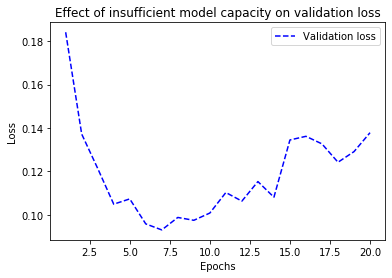

In [ ]:
import matplotlib.pyplot as plt

val_loss = history_large_model.history["val_loss"]
epochs = range(1, 21)

plt.plot(epochs, val_loss, "b--",
         label="Validation loss")

plt.title("Effect of insufficient model capacity on validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

## 5.4 일반화 향상법

모델 훈련이 어느 정도 잘 진행되어 일반화 성능이 향상되고 과대적합이 발생하기 시작하면
일반화를 극대화하는 방법에 집중해야 한다.
이를 위해 아래 요소들이 제대로 작동하는지 확인해야 한다.

- 데이터셋 큐레이션
- 특성 추출
- 조기 종료
- 규제

### 데이터셋 큐레이션

양질의 데이터셋을 모델 훈련에 사용해야 모델이 
데이터셋에 잠재되어 있는 다양체를 보다 잘 찾아낼 수 있다. 
양질의 데이터를 보다 많이 수집하는 일이 보다 적절한 모델을 찾으려는 노력보다
값어치가 높다. 

양질의 데이터의 기준은 다음과 같다.

- 충분한 양의 샘플(dense sampling): 훈련셋이 크면 클 수록 일반화 성능이 좋아짐.
- 레이블링 오류 최소화: 시각화를 통한 특이 사항 파악
- 데이터 클리닝과 결측치 처리(나중에 자세히 다룸)
- 유용한 특성 선택: 특성 수 감축

### 특성 공학

신경망 모델은 데이터셋에 잠재되어 있는 다양체를 찾기 위해 
여러 층을 통해 데이터셋의 표현을 다양한 방식으로 변환시킨다.
그렇게 해서 변환된 데이터셋의 표현들에 내재된 보다 쉽게 다양체를 찾아낸다. 

심층 신경망을 이용하는 이유가 모델 스스로 좋은 표현을 찾아내라고 유도하는 데에 있다.
즉, 모델 훈련에 가장 유용한 특성을 모델 스스로 직접 구성하도록 한다.
이런 점에서 적절한 심층 신경망을 구성하는 일이 중요하며
앞으로 다양한 문제를 다루면서 다양한 모델 구성과 훈련을 살펴볼 것이다.

그럼에도 불구하고 모델 훈련 시작 전에 유용한 특성으로 이루어진 데이터셋으로
변환할 수 있다면 모델의 성능을 더더욱 높일 수 있다.

- 모델 훈련이 보다 효율적으로 진행된다.
- 보다 적은 데이터를 이용하여 좋은 모델을 훈련할 수 있다.

이처럼 모델 훈련에 가장 유용한 특성을 구성하는 작업을 **특성 공학**(feature engineering)이라 한다.

### 조기 종료

모델 훈련 중에 검증셋에 대한 성능이 더 이상 좋아지지 않는 순간에 모델 훈련을 멈추는 것이 
**조기 종료**(early stopping)이다.
이를 위해 에포크마다 모델의 성능을 측정하여 가장 좋은 성능의 모델을 기억해 두고,
더 이상 좋아지지 않으면 그때까지의 최적 모델을 사용하도록 한다. 

케라스의 경우 `EarlyStopping` 이라는 콜백(callback) 객체를 사용하면 조기 종료 기능을
자동으로 수행한다. 콜백에 대해서는 나중에 자세히 다룬다.

### 규제

훈련 중이 모델이 데이터셋에 너무 민감하지 않게 유도하는 것을 **규제**(regularization)라 부른다.
즉, 모델 훈련에 규제를 가하여 모델을 보다 더 균형 있고 규칙적으로 예측하도록 유도하여
모델의 일반화 성능을 높힌다. 

여기서는 모델에 규제를 가하는 세 가지 기법을 IMDB 데이터셋을 이용하여 소개한다. 

#### 규제 기법 1: 신경망 크기 축소

앞서 보았듯이 모델을 층, 유닛의 수를 줄여 모델을 단순화 하면 
과대적합이 없거나 줄어든다. 
이유는 모델에 저장될 수 있는 정보량이 줄어들어 세세한 정보를 낱낱이 기억하기 보다는
보다 압축된 정보를 활용하도록 유도된다. 

모델이 너무 단순하면 아예 훈련이 제대로 되지 않을 수 있기에 적절하게 줄이도록 해야 한다.
하지만 이에 대한 이론적 기준은 없으며 실험을 통해 적절한 규제를 찾아내야 한다.
보통 적은 수의 층과 유닛을 사용하다가 점차 수를 늘려 나가는 것이 좋다.

아래 코드는 이전에 다루었던 IMDB 데이터셋을 이용한 모델 훈련이다. 

In [ ]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), _ = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

train_data = vectorize_sequences(train_data)

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

history_original = model.fit(train_data, train_labels,
                             epochs=20, batch_size=512, validation_split=0.4)

Epoch 1/20
30/30 [==============================] - 2s 39ms/step - loss: 0.5153 - accuracy: 0.7932 - val_loss: 0.3933 - val_accuracy: 0.8561
Epoch 2/20
30/30 [==============================] - 0s 13ms/step - loss: 0.3084 - accuracy: 0.9007 - val_loss: 0.3137 - val_accuracy: 0.8775
Epoch 3/20
30/30 [==============================] - 0s 11ms/step - loss: 0.2268 - accuracy: 0.9273 - val_loss: 0.2898 - val_accuracy: 0.8855
Epoch 4/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1800 - accuracy: 0.9407 - val_loss: 0.2806 - val_accuracy: 0.8873
Epoch 5/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1465 - accuracy: 0.9526 - val_loss: 0.2760 - val_accuracy: 0.8898
Epoch 6/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1238 - accuracy: 0.9620 - val_loss: 0.2993 - val_accuracy: 0.8831
Epoch 7/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1025 - accuracy: 0.9699 - val_loss: 0.3030 - val_accuracy: 0.8853
Epoch 8/20
30

은닉층의 유닛수를 4로 만들어보자.

In [ ]:
model = keras.Sequential([
    layers.Dense(4, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

history_smaller_model = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4)

Epoch 1/20
30/30 [==============================] - 1s 21ms/step - loss: 0.6269 - accuracy: 0.6606 - val_loss: 0.5702 - val_accuracy: 0.7327
Epoch 2/20
30/30 [==============================] - 0s 11ms/step - loss: 0.5360 - accuracy: 0.7881 - val_loss: 0.5297 - val_accuracy: 0.7474
Epoch 3/20
30/30 [==============================] - 0s 11ms/step - loss: 0.4868 - accuracy: 0.8447 - val_loss: 0.4943 - val_accuracy: 0.8366
Epoch 4/20
30/30 [==============================] - 0s 11ms/step - loss: 0.4519 - accuracy: 0.8819 - val_loss: 0.4754 - val_accuracy: 0.8583
Epoch 5/20
30/30 [==============================] - 0s 11ms/step - loss: 0.4253 - accuracy: 0.9059 - val_loss: 0.4696 - val_accuracy: 0.8405
Epoch 6/20
30/30 [==============================] - 0s 11ms/step - loss: 0.4037 - accuracy: 0.9209 - val_loss: 0.4668 - val_accuracy: 0.8411
Epoch 7/20
30/30 [==============================] - 0s 10ms/step - loss: 0.3857 - accuracy: 0.9339 - val_loss: 0.4619 - val_accuracy: 0.8470
Epoch 8/20
30

기존 모델과의 차이점은 다음과 같다.

- 기존 모델보다 과대적합이 늦게 발생한다.

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/original_model_vs_smaller_model_imdb.png" style="width:500px;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

이번엔 유닛 수를 크게 늘려보자.

In [ ]:
model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(512, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_larger_model = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4)

Epoch 1/20
30/30 [==============================] - 3s 88ms/step - loss: 0.5572 - accuracy: 0.7635 - val_loss: 0.3305 - val_accuracy: 0.8637
Epoch 2/20
30/30 [==============================] - 2s 73ms/step - loss: 0.2560 - accuracy: 0.8967 - val_loss: 0.2690 - val_accuracy: 0.8922
Epoch 3/20
30/30 [==============================] - 2s 71ms/step - loss: 0.1563 - accuracy: 0.9407 - val_loss: 0.3348 - val_accuracy: 0.8725
Epoch 4/20
30/30 [==============================] - 2s 72ms/step - loss: 0.0597 - accuracy: 0.9795 - val_loss: 0.3978 - val_accuracy: 0.8843
Epoch 5/20
30/30 [==============================] - 2s 72ms/step - loss: 0.1047 - accuracy: 0.9769 - val_loss: 0.3745 - val_accuracy: 0.8896
Epoch 6/20
30/30 [==============================] - 2s 72ms/step - loss: 0.0034 - accuracy: 0.9995 - val_loss: 0.5210 - val_accuracy: 0.8879
Epoch 7/20
30/30 [==============================] - 2s 71ms/step - loss: 0.1402 - accuracy: 0.9781 - val_loss: 0.4680 - val_accuracy: 0.8837
Epoch 8/20
30

기존 모델과의 차이점은 다음과 같다.

- 과대적합이 매우 빠르게 발생하며, 검증셋에 대한 성능이 매우 불안정하다.

**주의사항**: 검증셋이 너무 작아도 매우 불안정스러울 수 있다.

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/original_model_vs_larger_model_imdb.png" style="width:500px;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

#### 규제 기법 2: 가중치 규제

모델이 학습하는 파라미터(가중치와 편향)의 값이 작은 값을 갖도록 유도하는 기법이 
**가중치 규제**(weight regularization)이며,
크게 두 종류가 있다. 

- L1 규제: 절댓값이 상대적으로 보다 작은 가중치를 보다 빠르게 0이 되도록 유도.
    즉, 덜 중요한 특성을 무시하도록 유도.
- L2 규제: 가중치가 작은 값을 갖도록 유도.
    즉, 특정 특성에 심하게 휘둘리지 않도록 유도.

**참고**: L1 규제가 적용된 라쏘 회귀(Lasso regression)과 L2 규제가 적용된 릿지 회귀(Ridge regression)

<div align="center"><img src="https://codingalzi.github.io/handson-ml2/slides/images/ch04/lasso_vs_ridge_plot.png" style="width:550px;"></div>

그림 출처: [핸즈온 머신러닝(2판), 4장](https://github.com/ageron/handson-ml2)

아래 코드는 IMDB 훈련 모델에 L2 규제를 가한 결과를 보여준다.

- `regularizers.l2(0.002)`: 각 가중치의 제곱에 0.002 곱하기
- 규제는 훈련 중에만 적용되며 테스트에는 사용되지 않음.

In [ ]:
from tensorflow.keras import regularizers

model = keras.Sequential([
    layers.Dense(16,
                 kernel_regularizer=regularizers.l2(0.002),
                 activation="relu"),
    layers.Dense(16,
                 kernel_regularizer=regularizers.l2(0.002),
                 activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

history_l2_reg = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4)

Epoch 1/20
30/30 [==============================] - 2s 34ms/step - loss: 0.6023 - accuracy: 0.7710 - val_loss: 0.4744 - val_accuracy: 0.8630
Epoch 2/20
30/30 [==============================] - 0s 12ms/step - loss: 0.3990 - accuracy: 0.8978 - val_loss: 0.3953 - val_accuracy: 0.8819
Epoch 3/20
30/30 [==============================] - 0s 12ms/step - loss: 0.3301 - accuracy: 0.9161 - val_loss: 0.4116 - val_accuracy: 0.8601
Epoch 4/20
30/30 [==============================] - 0s 12ms/step - loss: 0.2985 - accuracy: 0.9259 - val_loss: 0.3822 - val_accuracy: 0.8756
Epoch 5/20
30/30 [==============================] - 0s 12ms/step - loss: 0.2757 - accuracy: 0.9331 - val_loss: 0.3550 - val_accuracy: 0.8863
Epoch 6/20
30/30 [==============================] - 0s 12ms/step - loss: 0.2655 - accuracy: 0.9389 - val_loss: 0.3583 - val_accuracy: 0.8848
Epoch 7/20
30/30 [==============================] - 0s 12ms/step - loss: 0.2526 - accuracy: 0.9412 - val_loss: 0.3646 - val_accuracy: 0.8826
Epoch 8/20
30

L2 규제를 가한 결과는 다음과 같다.

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/original_model_vs_l2_regularized_model_imdb.png" style="width:500px;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

`l2` 규제 대신에 `l1`, 또는 L1과 L2를 함께 사용하는 `l1_l2` 규제를 사용할 수 있다.

```python
regularizers.l1(0.001)
regularizers.l1_l2(l1=0.001, l2=0.001)
```

**참고**: 가중치 규제 기법은 보다 작은 크기의 딥러닝 모델에 효과적이다.
큰 딥러닝 모델에 대해서는 드롭아웃 기법이 보다 잘 작동한다.

#### 규제 기법 3: 드롭아웃 적용

**드롭아웃**은 무작위로 선택된 일정한 비율의 유닛을 끄는 것을 의미한다.
즉, 해당 유닛에 저장된 값을 0으로 처리한다. 

- 적절한 드롭아웃 비율을 답은 드롭아웃 층을 적절한 위치에 추가한다.

- 검증셋에 대해서는 드롭아웃을 적용하지 않는다. 대신 출력값을 지정된 비율만큼 줄인다.
    그래야 층에서 층으로 전달되는 값의 크기가 훈련할 때와 비슷하게 유지되기 때문이다.
    
아래 코드는 IMDB 데이터셋에 드롯아웃을 적용하여 훈련한다.

In [ ]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_dropout = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4)

Epoch 1/20
30/30 [==============================] - 1s 35ms/step - loss: 0.6332 - accuracy: 0.6373 - val_loss: 0.5116 - val_accuracy: 0.8513
Epoch 2/20
30/30 [==============================] - 0s 12ms/step - loss: 0.5115 - accuracy: 0.7645 - val_loss: 0.4120 - val_accuracy: 0.8725
Epoch 3/20
30/30 [==============================] - 0s 12ms/step - loss: 0.4286 - accuracy: 0.8241 - val_loss: 0.3393 - val_accuracy: 0.8822
Epoch 4/20
30/30 [==============================] - 0s 12ms/step - loss: 0.3633 - accuracy: 0.8619 - val_loss: 0.2936 - val_accuracy: 0.8875
Epoch 5/20
30/30 [==============================] - 0s 12ms/step - loss: 0.3172 - accuracy: 0.8840 - val_loss: 0.2843 - val_accuracy: 0.8866
Epoch 6/20
30/30 [==============================] - 0s 12ms/step - loss: 0.2727 - accuracy: 0.9035 - val_loss: 0.2721 - val_accuracy: 0.8911
Epoch 7/20
30/30 [==============================] - 0s 12ms/step - loss: 0.2486 - accuracy: 0.9129 - val_loss: 0.2784 - val_accuracy: 0.8914
Epoch 8/20
30

50%의 드롭아웃을 적용한 결과는 다음과 같다.

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/original_model_vs_dropout_regularized_model_imdb.png" style="width:500px;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)